In [1]:
import polars as pl
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threshold_helpers as th


In [2]:
np.random.seed(0)

In [3]:
df = pl.read_csv("CRC01_single_cell_table.csv")
df = df.to_pandas()

# subset for faster computation when debugging
#df = df.iloc[:5000, ]
#df

In [4]:
cols = df.columns
marker_cols = cols[1: -9]
coord_cols = cols[-9: -7]
# remove certain elements
marker_cols = [mc for mc in marker_cols if mc not in ["Hoechst", "Argo550", "AF1"]]
marker_cols

['CD31',
 'CD45',
 'CD68',
 'CD4',
 'FOXP3',
 'CD8a',
 'CD45RO',
 'CD20',
 'PD-L1',
 'CD3e',
 'CD163',
 'E-cadherin',
 'PD-1',
 'Ki67',
 'Pan-CK',
 'SMA']

In [5]:
adata = sc.read("temp_adata.h5ad")
print(adata)

/opt/miniconda3/envs/Summer2025/lib/python3.13/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1620375 × 16
    obs: 'CellID', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'leiden_clusters'
    var: 'mean', 'std'
    uns: 'leiden_clusters', 'leiden_clusters_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'log1p', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'


In [6]:
# Dominant markers
top_genes =  pd.DataFrame(adata.uns["rank_genes_groups"]["names"])
print(top_genes.iloc[0:3, ])

num_clusters = len(top_genes.columns)
print(num_clusters)

        0      1       2      3     4           5      6      7     8     9  \
0  Pan-CK   CD31  CD45RO   CD68  CD8a        Ki67    SMA    SMA  CD20  CD8a   
1   CD163    SMA    CD45  CD163  CD3e        PD-1  CD163  CD163  CD45  CD3e   
2     SMA  CD163   FOXP3    CD4  PD-1  E-cadherin   CD45   CD31  CD31  CD45   

   ...          16          17          18          19    20          21  \
0  ...  E-cadherin  E-cadherin      Pan-CK        Ki67  Ki67      Pan-CK   
1  ...        PD-1        PD-1  E-cadherin      Pan-CK  PD-1  E-cadherin   
2  ...        Ki67      Pan-CK        Ki67  E-cadherin  CD20        PD-1   

      22    23     24     25  
0   PD-1   SMA  PD-L1    CD4  
1   Ki67  CD31  FOXP3   CD68  
2  FOXP3   CD4   CD20  PD-L1  

[3 rows x 26 columns]
26


In [7]:
# extract exprs data from adata for further analysis
gene_df = sc.get.obs_df(adata, keys=["leiden_clusters", *marker_cols])
# convert to pandas
gene_df = pl.DataFrame(gene_df)
gene_df


leiden_clusters,CD31,CD45,CD68,CD4,FOXP3,CD8a,CD45RO,CD20,PD-L1,CD3e,CD163,E-cadherin,PD-1,Ki67,Pan-CK,SMA
cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0""",-0.556207,-0.540815,-0.480171,-0.733641,-0.595304,-0.54454,-2.140197,-0.712167,-1.850492,-0.931429,-0.265846,-0.922795,-1.488486,-0.654615,-0.848747,-0.594724
"""1""",2.499437,0.007949,-0.373668,-0.188009,0.746363,0.160836,-0.057212,1.649209,0.075837,-0.422012,-0.182821,-0.852734,-1.336224,-0.625078,-0.856469,-0.366507
"""11""",-0.158286,-0.588984,-0.618306,-1.012596,-0.632458,-0.523647,-2.377256,-0.707261,-1.994702,-0.971544,-0.418985,-0.930318,-1.727947,-0.671324,-0.853393,-0.564455
"""23""",0.180737,-0.539934,-0.48784,-0.037253,-0.233485,-0.342784,-1.096966,-0.370084,-1.049234,-0.651899,-0.183911,-0.906881,-1.22947,-0.586233,-0.993286,10.399103
"""23""",0.045433,-0.5195,-0.445452,-0.108752,-0.202792,-0.309482,-0.987952,-0.304166,-0.803446,-0.5679,-0.144325,-0.898147,-1.038596,-0.562329,-0.952062,7.46777
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""15""",-0.998272,-0.399482,-0.644334,-1.354013,0.021191,-0.330093,-1.926376,-2.502209,-2.561982,-1.72657,0.962086,-1.331132,-0.652609,-0.985774,-0.515843,-1.58076
"""15""",-0.916433,-0.533909,-0.639261,-1.557495,0.045208,-0.290332,-1.768292,-2.367272,-2.471242,-1.779485,0.861666,-1.316391,-0.557771,-0.992026,-0.52479,-1.364717
"""15""",-0.986209,-0.544336,-0.659428,-1.394802,0.054706,-0.292513,-1.797471,-2.484632,-2.433621,-1.752095,0.935798,-1.330958,-0.536778,-1.002393,-0.519558,-1.271408


In [8]:
# print number of cells in each cluster
cells_per_cluster = [0] * num_clusters
for i in range(0, num_clusters):
    temp = gene_df.filter(pl.col("leiden_clusters").cast(pl.Int32)==i).shape[0]
    cells_per_cluster[i] = temp
    print(f"{temp} cells in cluster {i}")

print(cells_per_cluster)

42917 cells in cluster 0
63524 cells in cluster 1
24307 cells in cluster 2
112057 cells in cluster 3
28177 cells in cluster 4
74780 cells in cluster 5
244518 cells in cluster 6
80687 cells in cluster 7
12805 cells in cluster 8
68404 cells in cluster 9
80728 cells in cluster 10
9659 cells in cluster 11
70177 cells in cluster 12
49338 cells in cluster 13
46807 cells in cluster 14
23057 cells in cluster 15
83619 cells in cluster 16
51401 cells in cluster 17
250302 cells in cluster 18
29603 cells in cluster 19
71199 cells in cluster 20
78337 cells in cluster 21
19850 cells in cluster 22
3763 cells in cluster 23
274 cells in cluster 24
85 cells in cluster 25
[42917, 63524, 24307, 112057, 28177, 74780, 244518, 80687, 12805, 68404, 80728, 9659, 70177, 49338, 46807, 23057, 83619, 51401, 250302, 29603, 71199, 78337, 19850, 3763, 274, 85]


In [9]:
# examine first few percentiles of distribution for each marker

# ensure that the next transformation (max of epsilon and x - some percentile) is decently valid

for marker in marker_cols:
    temp = adata[:, marker].layers["raw"].flatten()
    temp = pd.Series(temp)
    #print(f"{marker} minimum: {temp.min()}")
    #print(f"{marker} 1st percentile: {temp.quantile(0.01)}")
    #print(f"{marker} 5th percentile: {temp.quantile(0.05)}")
    #print(f"{marker} 50th percentile: {temp.quantile(0.50)}")

In [10]:
marker_cols

['CD31',
 'CD45',
 'CD68',
 'CD4',
 'FOXP3',
 'CD8a',
 'CD45RO',
 'CD20',
 'PD-L1',
 'CD3e',
 'CD163',
 'E-cadherin',
 'PD-1',
 'Ki67',
 'Pan-CK',
 'SMA']

In [11]:
adata.obs.describe()

,CellID,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation
count,1.620375e+06,1.620375e+06,1.620375e+06,1.620375e+06,1.620375e+06,1.620375e+06,1.620375e+06,1.620375e+06
mean,8.101880e+05,4.419592e+02,2.949640e+01,1.907933e+01,7.105648e-01,9.136845e-01,6.483661e-01,1.392884e-02
std,4.677621e+05,2.194717e+02,8.949611e+00,4.786046e+00,1.498438e-01,4.758412e-02,8.970525e-02,9.467708e-01
min,1.000000e+00,1.900000e+01,5.840021e+00,1.408847e+00,0.000000e+00,4.302326e-01,1.282051e-01,-1.570796e+00
25%,4.050945e+05,2.860000e+02,2.346035e+01,1.576575e+01,6.200230e-01,8.910256e-01,5.873016e-01,-8.324490e-01
50%,8.101880e+05,4.060000e+02,2.813202e+01,1.905119e+01,7.351219e-01,9.248555e-01,6.526611e-01,1.194969e-02
75%,1.215282e+06,5.560000e+02,3.393225e+01,2.218384e+01,8.253284e-01,9.487657e-01,7.153846e-01,8.748713e-01
max,1.620375e+06,3.751000e+03,1.727784e+02,6.348622e+01,9.977853e-01,1.000000e+00,9.857143e-01,1.570796e+00


In [12]:
# type "gaussian", "gamma", "otsu", or "triangle" to select the method

method = input("Enter the thresholding method (gaussian, gamma, otsu, triangle): ").strip().lower()

for marker in marker_cols:
    print(f"Processing marker: {marker}")
    
    if method == "gaussian":
        th.stratify_by_marker(adata, marker, 2)
    elif method == "gamma":
        th.gamma_strat(adata, marker, 2)
    elif method == "otsu":
        th.otsu_thresholding(adata, marker)
    elif method == "triangle":
        th.triangle_method(adata, marker)
    else:
        print("Invalid")    

# restart the kernel each time when switching for safety

Processing marker: CD31
Processing marker: CD45
Processing marker: CD68
Processing marker: CD4
Processing marker: FOXP3
Processing marker: CD8a
Processing marker: CD45RO
Processing marker: CD20
Processing marker: PD-L1
Processing marker: CD3e
Processing marker: CD163
Processing marker: E-cadherin
Processing marker: PD-1
Processing marker: Ki67
Processing marker: Pan-CK
Processing marker: SMA


In [13]:
# reference dictionary for cell types

cell_ref = {
    "Tumor Cell": {"pos": ["E-cadherin"], "neg": ["CD45", "CD3e", "CD8a", "CD20", "CD68", "FOXP3", "SMA", "CD31", "CD4", "CD45RO", "CD163"]},
    "CD8 T Cell": {"pos": ["CD45", "CD3e", "CD8a"], "neg": ["CD31", "CD68", "CD4", "FOXP3", "CD20", "CD163", "E-cadherin", "Pan-CK", "SMA"]},
    "CD4 T Cell": {"pos": ["CD45", "CD3e", "CD4"], "neg": ["CD31", "CD68", "CD8a", "CD20", "CD163", "E-cadherin", "Pan-CK", "SMA"]},
    "Tregs": {"pos": ["CD45", "CD3e", "FOXP3"], "neg": ["CD31", "CD68", "CD20", "CD163", "E-cadherin", "Pan-CK", "SMA"]},
    "T-memory": {"pos": ["CD45", "CD3e", "CD45RO"], "neg": ["CD31", "CD68", "FOXP3", "CD20", "CD163", "E-cadherin", "Pan-CK", "SMA"]},
    "B Cell": {"pos": ["CD45", "CD20"], "neg": ["CD3e", "CD8a", "CD68", "FOXP3", "SMA", "CD31", "CD4", "CD45RO", "CD163", "E-cadherin", "Pan-CK"]},
    "Fibroblast": {"pos": ["SMA"], "neg": ["CD3e", "CD8a", "CD68", "FOXP3", "CD45", "CD20", "CD31", "CD4", "CD45RO", "CD163", "E-cadherin", "Pan-CK"]},
    "Endothelium": {"pos": ["CD31"], "neg": ["CD3e", "CD8a", "CD68", "FOXP3", "CD45", "CD20", "SMA", "CD4", "CD45RO", "CD163", "E-cadherin", "Pan-CK"]},
    "Macrophage": {"pos": ["CD45", "CD68"], "neg": ["CD4", "FOXP3", "CD8a", "CD45RO", "CD20", "CD3e", "E-cadherin", "Pan-CK", "SMA"]}
}

In [14]:
met = adata.obs
met = met.iloc[:, 8:]
met

,leiden_clusters,CD31_strat,CD45_strat,CD68_strat,CD4_strat,FOXP3_strat,CD8a_strat,CD45RO_strat,CD20_strat,PD-L1_strat,CD3e_strat,CD163_strat,E-cadherin_strat,PD-1_strat,Ki67_strat,Pan-CK_strat,SMA_strat
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620370,15,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1620371,15,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1620372,15,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1620373,15,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [15]:
# currently -> each cell has a positive or negative value for each marker

# desired -> for each cluster, what are the numbers of each cell type?

# intermediate -> for each cell, use the cell reference to annotate the cell type. if none match, then "Unknown"

In [16]:
# to met, add a new column of "Cell Type" (annotated using the cell_ref dictionary)

for cell_type, marker_dict in cell_ref.items():
    print(f"Processing cell type: {cell_type}")
    pos_markers = marker_dict["pos"]
    pos_markers = [marker + "_strat" for marker in pos_markers]
    neg_markers = marker_dict["neg"]
    neg_markers = [marker + "_strat" for marker in neg_markers]
    pos_mask = np.all([met[marker] > 0 for marker in pos_markers], axis=0)
    neg_mask = np.all([met[marker] <= 0 for marker in neg_markers], axis=0)

    cell_type_mask = pos_mask & neg_mask
    met.loc[cell_type_mask, "Cell Type"] = cell_type

# fill in any blanks in "Cell Type" column with "Not Assigned"
met["Cell Type"].fillna("Not Assigned", inplace=True)
    

Processing cell type: Tumor Cell
Processing cell type: CD8 T Cell
Processing cell type: CD4 T Cell
Processing cell type: Tregs
Processing cell type: T-memory
Processing cell type: B Cell
Processing cell type: Fibroblast
Processing cell type: Endothelium
Processing cell type: Macrophage


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_60567/2897235710.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  met["Cell Type"].fillna("Not Assigned", inplace=True)


In [17]:
# print total number of cells assigned to each cell type
for cell_type in cell_ref.keys():
    count = (met["Cell Type"] == cell_type).sum()
    print(f"Total cells assigned to {cell_type}: {count} ({count / len(met) * 100:.2f}%)")

print(f"Total cell percent not assigned to any cell type: {(met['Cell Type'] == 'Not Assigned').sum()} {(met['Cell Type'] == 'Not Assigned').sum() / len(met) * 100:.2f}%")

Total cells assigned to Tumor Cell: 787656 (48.61%)
Total cells assigned to CD8 T Cell: 7382 (0.46%)
Total cells assigned to CD4 T Cell: 6663 (0.41%)
Total cells assigned to Tregs: 7052 (0.44%)
Total cells assigned to T-memory: 29829 (1.84%)
Total cells assigned to B Cell: 1970 (0.12%)
Total cells assigned to Fibroblast: 153164 (9.45%)
Total cells assigned to Endothelium: 22180 (1.37%)
Total cells assigned to Macrophage: 23261 (1.44%)
Total cell percent not assigned to any cell type: 581218 35.87%


In [18]:
output_sheet = pl.DataFrame({
    # first column title "Cluster", fill with cluster numbers
    # second, third, fourth columns fill with dominant markers in each cluster (given by top genes in scanpy))
    # top_genes
    # fifth column title "Total Cells", fill with total cells in cluster (cells_per_cluster)
    # empty sixth column with "Expected Cell Type" (manually filled in)
    # empty seventh columns with "Primary Cell Type" (manually filled in)
    # empty eighth column with "Secondary Cell Type" (manually filled in)
    "Cluster": list(range(num_clusters)),
    "Dominant Marker 1": top_genes.iloc[0, :],
    "Dominant Marker 2": top_genes.iloc[1, :],
    "Dominant Marker 3": top_genes.iloc[2, :],
    "Expected Cell Type (Clustering-based)": ["" for _ in range(num_clusters)],
    "Total Cells": cells_per_cluster,
    "Primary Cell Type (%)": ["" for _ in range(num_clusters)],
    "Secondary Cell Type (%)": ["" for _ in range(num_clusters)]
})

In [19]:
query_list = [
    [["E-cadherin", "Pan-CK"], "OR"],
    [["E-cadherin", "Pan-CK"], "AND"],
    [["CD31"]],
    [["SMA"]],
    [["CD45"]],
    [["CD68"]],
    [["CD45", "CD68"], "AND"],
    [["CD45", "CD68", "CD163"], "AND"],
    [["CD3e"]],
    [["CD45", "CD3e"], "AND"],
    [["CD8a"]],
    [["CD45", "CD3e", "CD8a"], "AND"],
    [["CD4"]],
    [["CD45", "CD3e", "CD4"], "AND"],
    [["CD20"]],
    [["CD45", "CD20"], "AND"]
]

for query in query_list:
    temp = th.print_counts(met, 26, query)
    #print("-------------------------------------\n" \
    #"-------------------------------------\n" )

    # for each iteration, add a column
    column_name = ", ".join(query[0]) + ", " + query[1] if len(query) > 1 else ", ".join(query[0])
    #print(f"Column name: {column_name}")
    
    cluster_counts_df = pl.DataFrame({
        "Cluster": list(range(len(temp))),
        column_name: temp
    })
    

    output_sheet = output_sheet.join(cluster_counts_df, on="Cluster", how="left")

output_sheet

# convert to pandas to make life easier
output_sheet = output_sheet.to_pandas()

In [20]:
# fill in primary cell type (%) and secondary cell type (%) using met

# convert cluster labels to integer to make analysis easier
met["leiden_clusters"] = met["leiden_clusters"].astype(int)

# remove "Not Assigned" cells from met
met = met[met["Cell Type"] != "Not Assigned"]

for i in range(num_clusters):
    tab = met.loc[met["leiden_clusters"] == i, "Cell Type"].value_counts()
    print(tab)
    # get most common cell type
    if tab.empty:
        primary_cell_type = "None"
        primary_cell_type_count = 0
    else:
        primary_cell_type = tab.idxmax()
        primary_cell_type_count = tab.max()

    # get second most common cell type
    if len(tab) < 2:
        secondary_cell_type = "None"
        secondary_cell_type_count = 0
    else:
        secondary_cell_type = tab.nlargest(2).index[1]
        secondary_cell_type_count = tab.nlargest(2).values[1]

    # calculate percentage and assign back to output_sheet
    primary_cell_type_percent = primary_cell_type_count / cells_per_cluster[i] * 100
    secondary_cell_type_percent = secondary_cell_type_count / cells_per_cluster[i] * 100

    output_sheet.loc[output_sheet["Cluster"] == i, "Primary Cell Type (%)"] = f"{primary_cell_type} ({primary_cell_type_percent:.2f}%)"
    output_sheet.loc[output_sheet["Cluster"] == i, "Secondary Cell Type (%)"] = f"{secondary_cell_type} ({secondary_cell_type_percent:.2f}%)"

Cell Type
Tumor Cell    7355
Fibroblast     248
Macrophage       1
Name: count, dtype: int64
Cell Type
Endothelium    22130
Fibroblast      2416
Macrophage       355
Tumor Cell        63
T-memory          13
CD4 T Cell         6
Name: count, dtype: int64
Cell Type
Macrophage    736
T-memory       96
B Cell          4
Tumor Cell      2
CD4 T Cell      1
Name: count, dtype: int64
Cell Type
Macrophage     19778
T-memory         225
Tumor Cell       176
CD4 T Cell       174
Fibroblast       146
Endothelium        1
Name: count, dtype: int64
Cell Type
Tumor Cell    9880
CD8 T Cell      63
T-memory        53
CD4 T Cell       5
Fibroblast       3
Macrophage       2
Tregs            1
Name: count, dtype: int64
Cell Type
Tumor Cell    71731
Fibroblast        2
Name: count, dtype: int64
Cell Type
Fibroblast     72125
Macrophage      2170
Tumor Cell       358
T-memory         315
CD4 T Cell       313
Endothelium        9
CD8 T Cell         1
Name: count, dtype: int64
Cell Type
Fibroblast    71657

In [21]:
output_sheet.head()

,Cluster,Dominant Marker 1,Dominant Marker 2,Dominant Marker 3,Expected Cell Type (Clustering-based),Total Cells,Primary Cell Type (%),Secondary Cell Type (%),"E-cadherin, Pan-CK, OR","E-cadherin, Pan-CK, AND",...,"CD45, CD68, AND","CD45, CD68, CD163, AND",CD3e,"CD45, CD3e, AND",CD8a,"CD45, CD3e, CD8a, AND",CD4,"CD45, CD3e, CD4, AND",CD20,"CD45, CD20, AND"
0,0,Pan-CK,CD163,SMA,,42917,Tumor Cell (17.14%),Fibroblast (0.58%),30214,6474,...,15,0,1,0,14,0,1,0,0,0
1,1,CD31,SMA,CD163,,63524,Endothelium (34.84%),Fibroblast (3.80%),651,196,...,1075,474,1363,1216,498,240,1357,601,154,133
2,2,CD45RO,CD45,FOXP3,,24307,Macrophage (3.03%),T-memory (0.39%),2660,674,...,4543,1782,947,630,187,95,2369,408,877,715
3,3,CD68,CD163,CD4,,112057,Macrophage (17.65%),T-memory (0.20%),8604,3242,...,58722,46518,9801,9690,1906,686,41893,8717,262,204
4,4,CD8a,CD3e,PD-1,,28177,Tumor Cell (35.06%),CD8 T Cell (0.22%),27716,23909,...,253,38,9733,8212,9056,5643,2104,776,0,0


In [23]:
output_sheet.to_csv(f"CRC01_{method}_celltyping.csv")

In [ ]:
#met = adata.obs
#
#query_list = [
#    [["E-cadherin", "Pan-CK"], "OR"],
#    [["E-cadherin", "Pan-CK"], "AND"],
#    [["CD31"]],
#    [["SMA"]],
#    [["CD45"]],
#    [["CD68"]],
#    [["CD45", "CD68"], "AND"],
#    [["CD45", "CD68", "CD163"], "AND"],
#    [["CD3e"]],
#    [["CD45", "CD3e"], "AND"],
#    [["CD8a"]],
#    [["CD45", "CD3e", "CD8a"], "AND"],
#    [["CD4"]],
#    [["CD45", "CD3e", "CD4"], "AND"],
#    [["CD20"]],
#    [["CD45", "CD20"], "AND"]
#]
#
#output_sheet = pl.DataFrame({
#    # first column title "Cluster", fill with cluster numbers
#    # second, third, fourth columns fill with dominant markers in each cluster (given by top genes in scanpy))
#    # top_genes
#    # fifth column title "Total Cells", fill with total cells in cluster (cells_per_cluster)
#    # empty sixth column with "Expected Cell Type" (manually filled in)
#    # empty seventh columns with "Primary Cell Type" (manually filled in)
#    # empty eighth column with "Secondary Cell Type" (manually filled in)
#    "Cluster": list(range(26)),
#    "Dominant Marker 1": top_genes.iloc[0, :],
#    "Dominant Marker 2": top_genes.iloc[1, :],
#    "Dominant Marker 3": top_genes.iloc[2, :],
#    "Expected Cell Type (Clustering-based)": ["" for _ in range(26)],
#    "Total Cells": cells_per_cluster,
#    "Primary Cell Type (%)": ["" for _ in range(26)],
#    "Secondary Cell Type (%)": ["" for _ in range(26)]
#})
#
#for query in query_list:
#    temp = print_counts(met, 26, query)
#    #print("-------------------------------------\n" \
#    #"-------------------------------------\n" )
#
#    # for each iteration, add a column
#    column_name = ", ".join(query[0]) + ", " + query[1] if len(query) > 1 else ", ".join(query[0])
#    #print(f"Column name: {column_name}")
#    
#    cluster_counts_df = pl.DataFrame({
#        "Cluster": list(range(len(temp))),
#        column_name: temp
#    })
#    
#
#    output_sheet = output_sheet.join(cluster_counts_df, on="Cluster", how="left")

# fill in the "primary cell type (%)" and "secondary cell type (%)" columns
# create an identical new matrix to fill in, only with one query for each desired cell type

#temp_sheet = pl.DataFrame({
#    "Cluster": list(range(26)),
#    "Total Cells": cells_per_cluster,
#    "Primary Cell Type (%)": ["" for _ in range(26)],
#    "Secondary Cell Type (%)": ["" for _ in range(26)]
#})

#unique_query = {
#    "Tumor": [["E-cadherin", "Pan-CK"], "AND"],
#    "Endothelium": [["CD31"]],
#    "Fibroblast": [["SMA"]],
#    "Macrophage": [["CD45", "CD68"], "AND"],
#    "CD8 T Cell": [["CD45", "CD3e", "CD8a"], "AND"],
#    "CD4 T Cell": [["CD45", "CD3e", "CD4"], "AND"],
#    "B Cell": [["CD45", "CD20"], "AND"]
#}
#
#for key, query in unique_query.items():
#    temp = print_counts(met, 26, query)
#    #"-------------------------------------\n" )
#    #print("-------------------------------------\n" \
#    #"-------------------------------------\n" )
#
#    #print(f"Column name: {key}")
#    cluster_counts_df = pl.DataFrame({
#        "Cluster": list(range(len(temp))),
#        key: temp
#    })
#    
#
#    temp_sheet = temp_sheet.join(cluster_counts_df, on="Cluster", how="left")
#
##print(temp_sheet)
#
## now to fill in the primary cell type and secondary cell type columns, by row
## for primary, take the max number of cells in the row (Only looking at columns 5 and onward), and divide that by the total number of cells in the cluster for a percentage
## for secondary, take the second most and do the same
## fill in the values as {cell type}, which is the column name in the temp_sheet, followed by the percentage in parentheses
#
#for i in range(26):
#    # get relevant values
#    row = temp_sheet[i, 4:].to_numpy()[0]
#    #print(len(row))
#    #print(row)
#
#    sorted_idx = np.argsort(row)
#    primary_value = row[sorted_idx[-1]]
#    secondary_value = row[sorted_idx[-2]]
#
#    # calculate percentages
#    primary_percentage = (primary_value / cells_per_cluster[i]) * 100 if cells_per_cluster[i] > 0 else 0
#    secondary_percentage = (secondary_value / cells_per_cluster[i]) * 100 if cells_per_cluster[i] > 0 else 0
#
#    # fill in the values
#    temp_sheet[i, "Primary Cell Type (%)"] = f"{temp_sheet.columns[sorted_idx[-1] + 4]} ({primary_percentage:.2f}%)"
#    temp_sheet[i, "Secondary Cell Type (%)"] = f"{temp_sheet.columns[sorted_idx[-2] + 4]} ({secondary_percentage:.2f}%)"
#
#
##print(temp_sheet.head())
#
## copy the percentage cell types (third and fourth columns) to output_sheet 7th and 8th columns
#cols = temp_sheet.columns[2:4]
#
#output_sheet = output_sheet.with_columns(temp_sheet.select(cols))
#print(output_sheet.head())

# transpose the sheets
#output_sheet = output_sheet.transpose(include_header=True, header_name="X")
#temp_sheet = temp_sheet.transpose(include_header=True, header_name="X")

# export output_sheet as csv and open in excel

#filename2 = input("Enter final file name: ")
#output_sheet.write_csv(filename2)


In [ ]:
#gene_df = sc.get.obs_df(adata, keys=["leiden_clusters", *marker_cols])
#th.plot_strat(gene_df, "SMA")

In [ ]:
# 8/16 to-do

# complete reference dict of pos and neg markers for cell types - done

# modifiy code to correctly identify cells based on reference dict

# read papers on otsu's thresholding and triangle method - done

# go back and refine marker stratification code - done

# re-generate table and complete new table

# update Dr. Lee

Manual Cell Thresholding Below (OLD)


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_66575/3644594971.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_df.groupby("leiden_clusters")["CD8a_gmm_labels"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

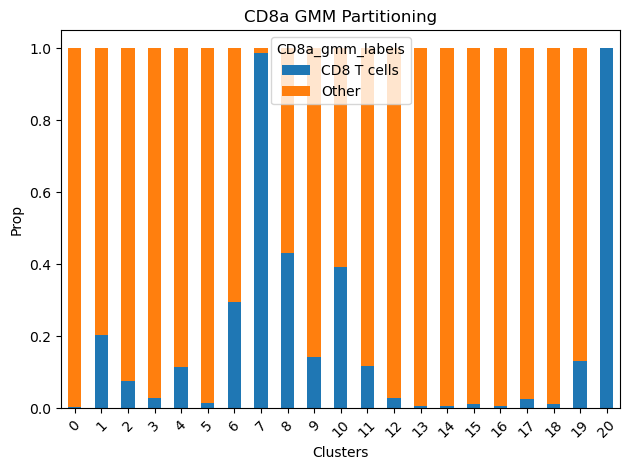

In [ ]:
#log_cd8_exprs = adata[:, "CD8a"].layers["log1p"].flatten()
#
#gmm = GaussianMixture(n_components=2, random_state=0)
#gmm.fit(log_cd8_exprs.reshape(-1, 1))
## Predict cluster labels
#log_cd8a_labels = gmm.predict(log_cd8_exprs.reshape(-1, 1))
## make log_cd8_labels categorical
#log_cd8a_labels = np.where(log_cd8a_labels == 1, "CD8 T cells", "Other")
#adata.obs["CD8a_gmm_labels"] = log_cd8a_labels
#
#plt.figure(figsize=(10, 6))
#gene_df["CD8a_gmm_labels"] = adata.obs["CD8a_gmm_labels"]
#gene_df.groupby("leiden_clusters")["CD8a_gmm_labels"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
#plt.title("CD8a GMM Partitioning")
#plt.xlabel("Clusters")
#plt.ylabel("Prop")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

In [21]:
# clusters 1 and 15 are shown to possibly be CD8 T cells

# check overlap in cell typing labels and cluster labels

temp = pl.DataFrame({
    "cellID": adata.obs_names,
    "cluster_labs": adata.obs["leiden_clusters"],
    "gmm_labs": adata.obs["CD8a_gmm_labels"]
})

# print total cells thresholded
count1 = temp.filter(((pl.col("cluster_labs").cast(pl.Int32)==1)) | (pl.col("cluster_labs").cast(pl.Int32)==15)).shape[0]
count2 = temp.filter(pl.col("gmm_labs")=="CD8 T cells").shape[0]

print(f"Total cells in clusters 1 and 15: {count1}")
print(f"Total cells by GMM: {count2}")

overlap = temp.filter((((pl.col("cluster_labs").cast(pl.Int32)==1)) | (pl.col("cluster_labs").cast(pl.Int32)==15))
                       & (pl.col("gmm_labs")=="CD8 T cells")).shape[0]

print(f"Overlap of two methods: {overlap}")
print(f"Percent of cells in clusters 1 and 15 that are marked as CD8 T cells: {overlap/count1:.2%}")

Total cells in clusters 1 and 15: 78984
Total cells by GMM: 183675
Overlap of two methods: 74962
Percent of cells in clusters 1 and 15 that are marked as CD8 T cells: 94.91%


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_66575/2241367654.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_df.groupby("leiden_clusters")["CD3e_labs"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

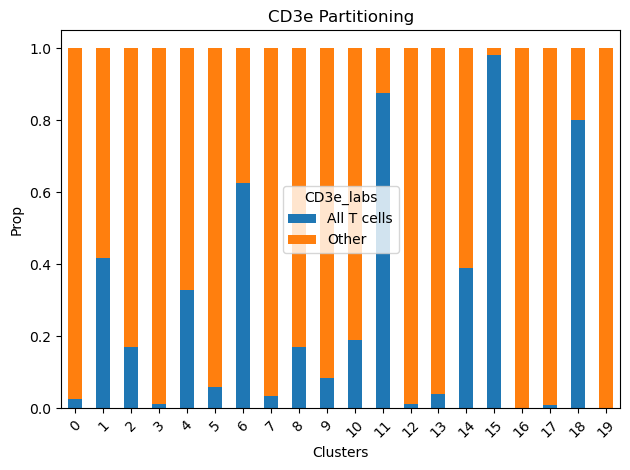

In [ ]:
## identify all T cells (using CD3e, a pan-T cell marker)
#
#log_cd3e_exprs = adata[:, "CD3e"].layers["log1p"].flatten()
#
#gmm = GaussianMixture(n_components=2, random_state=0)
#gmm.fit(log_cd3e_exprs.reshape(-1, 1))
## Predict cluster labels
#log_cd3e_labels = gmm.predict(log_cd3e_exprs.reshape(-1, 1))
## make log_cd8_labels categorical
#log_cd3e_labels = np.where(log_cd3e_labels == 1, "All T cells", "Other")
#adata.obs["CD3e_labs"] = log_cd3e_labels
#
#plt.figure(figsize=(10, 6))
#gene_df["CD3e_labs"] = adata.obs["CD3e_labs"]
#gene_df.groupby("leiden_clusters")["CD3e_labs"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
#plt.title("CD3e Partitioning")
#plt.xlabel("Clusters")
#plt.ylabel("Prop")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()



In [ ]:
# clusters 6, 11, 15, and 18 show the most promise as being T cells
# clusters 1 and 14 have slightly less proportion

# check how many of the CD8 T cells identified before are also marked as CD3e+ according to this model


#temp = pl.DataFrame({
#    "cellID": adata.obs_names,
#    "CD8": adata.obs["CD8a_gmm_labels"],
#    "CD3": adata.obs["CD3e_labs"]
#})
#
## print total cells thresholded
#count1 = temp.filter((pl.col("CD8")=="CD8 T cells")).shape[0]
#count2 = temp.filter(pl.col("CD3")=="All T cells").shape[0]
#
#print(f"Total CD8 T cells: {count1}")
#print(f"Total T cells: {count2}")
#
#overlap = temp.filter((pl.col("CD8")=="CD8 T cells")
#                       & (pl.col("CD3")=="All T cells")).shape[0]
#
#print(f"Proportion of CD8 T cells also exhibiting CD3: {overlap/count1:.2%}")


Total CD8 T cells: 183675
Total T cells: 263642
Proportion of CD8 T cells also exhibiting CD3: 73.78%


/var/folders/br/wg7_xdjd56j7rb8h39m_2f240000gn/T/ipykernel_66575/3602326862.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_df.groupby("leiden_clusters")["CD20_labs"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)


<Figure size 1000x600 with 0 Axes>

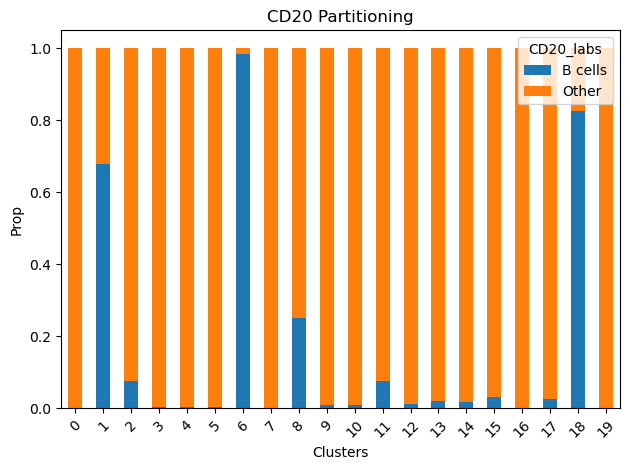

In [ ]:
# B cell identification using gmm, CD20
#
#log_cd20_exprs = adata[:, "CD20"].layers["log1p"].flatten()
#
#gmm = GaussianMixture(n_components=2, random_state=0)
#gmm.fit(log_cd20_exprs.reshape(-1, 1))
## Predict cluster labels
#log_cd20_labels = gmm.predict(log_cd20_exprs.reshape(-1, 1))
## make log_cd8_labels categorical
#log_cd20_labels = np.where(log_cd20_labels == 1, "B cells", "Other")
#adata.obs["CD20_labs"] = log_cd20_labels
#
#plt.figure(figsize=(10, 6))
#gene_df["CD20_labs"] = adata.obs["CD20_labs"]
#gene_df.groupby("leiden_clusters")["CD20_labs"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
#plt.title("CD20 Partitioning")
#plt.xlabel("Clusters")
#plt.ylabel("Prop")
#plt.xticks(rotation=45)
#plt.tight_layout()
#plt.show()

In [ ]:
# seems like pretty clearly clusters 6 and 18 are B cells

# seems like cluster 1 is pretty controversial

# check if there is overlap between identified B and T cells

#temp = pl.DataFrame({
#    "cellID": adata.obs_names,
#    "B cells": adata.obs["CD20_labs"],
#    "T cells": adata.obs["CD3e_labs"],
#    "clusters": adata.obs["leiden_clusters"]
#})
#
#count1 = temp.filter((pl.col("T cells")=="All T cells")).shape[0]
#count2 = temp.filter(pl.col("B cells")=="B cells").shape[0]
#
#print(f"Total T cells: {count1}")
#print(f"Total B cells: {count2}")
#
#overlap = temp.filter((pl.col("T cells")=="All T cells")
#                       & (pl.col("B cells")=="B cells")).shape[0]
#
#print(f"Overlap in B and T cell annotation: {overlap}")
#
#overlap2 = temp.filter((pl.col("T cells")=="All T cells")
#                       & (pl.col("B cells")=="B cells") 
#                       & (pl.col("clusters").cast(pl.Int32)==1)).shape[0]
#
#print(f"Cells in cluster 1 that are annotated as both B and T cells: {overlap2}")


Total T cells: 263642
Total B cells: 48251
Overlap in B and T cell annotation: 26043
Cells in cluster 1 that are annotated as both B and T cells: 5056


In [33]:
adata.obs

,CellID,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation,leiden_clusters,CD8a_gmm_labels,CD3e_labs,CD20_labs
0,1,588,41.882124,18.370334,0.898673,0.981636,0.864706,1.533761,0,CD8 T cells,All T cells,Other
1,2,740,43.965194,22.187973,0.863312,0.946292,0.764463,-1.530993,1,CD8 T cells,Other,B cells
2,3,193,18.694776,13.708441,0.679931,0.914692,0.756863,-0.904913,0,CD8 T cells,All T cells,Other
3,4,408,23.768887,21.976172,0.380995,0.978417,0.771267,0.603646,5,Other,Other,Other
4,5,1494,74.087383,26.469302,0.934001,0.918254,0.507473,0.967785,5,Other,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
1620370,1620371,497,28.448086,22.773829,0.599279,0.935970,0.806818,1.437491,4,Other,All T cells,B cells
1620371,1620372,221,21.540405,13.837058,0.766389,0.876984,0.619048,1.066740,4,Other,All T cells,B cells
1620372,1620373,394,26.139311,19.355939,0.672066,0.951691,0.721612,1.274071,4,Other,All T cells,B cells
1620373,1620374,339,22.896479,18.906752,0.564037,0.960340,0.770455,1.221391,4,Other,All T cells,B cells
